# **LLM Serving with Apigee**

<table align="left">
    <td style="text-align: center">
        <a href="https://colab.research.google.com/github/GoogleCloudPlatform/apigee-samples/blob/main/llm-semantic-cache-v2/llm_semantic_cache_v2.ipynb">
          <img src="https://github.com/GoogleCloudPlatform/apigee-samples/blob/main/images/icon32.png?raw=true" alt="Google Colaboratory logo\"><br> Open in Colab
        </a>
      </td>
      <td style="text-align: center">
        <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapigee-samples%2Fmain%2Fllm-semantic-cache-v2%2Fllm_semantic_cache_v2.ipynb">
          <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
        </a>
      </td>    
      <td style="text-align: center">
        <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/apigee-samples/main/llm-semantic-cache-v2/llm_semantic_cache_v2.ipynb">
          <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
        </a>
      </td>
      <td style="text-align: center">
        <a href="https://github.com/GoogleCloudPlatform/apigee-samples/blob/main/llm-semantic-cache-v2/llm_semantic_cache_v2.ipynb">
          <img src="https://github.com/GoogleCloudPlatform/apigee-samples/blob/main/images/github-mark.png?raw=true" width="30" alt="GitHub logo"><br> View on GitHub
        </a>
      </td>
</table>
<br />
<br />
<br />

# Semantic Cache Sample

This sample performs a cache lookup of responses on Apigee's Cache layer and Vector Search as an embeddings database. It operates by comparing the vector proximity of the prompt to prior requests and using a configurable similarity score threshold. This sample uses the Semantic Caching policies available in Apigee.

![architecture](https://github.com/GoogleCloudPlatform/apigee-samples/blob/main/llm-semantic-cache/images/arch-1.png?raw=1)

# Benefits of a Semantic Cache Layer with Apigee:

* **Reduced Response Times**: The cache layer significantly reduces response times for repeated queries, as Apigee efficiently stores and retrieves frequently accessed data.
* **Improved Efficiency**: By leveraging the caching capabilities of Apigee, unnecessary calls to the underlying model will be minimized, leading to optimized LLM costs.
* **Scalability**: The Apigee Cache Layer is managed and distributed, enhancing platform scalability without operational overhead.


## About Vertex AI Vector Search API and Embeddings API

[**Vertex AI Vector Search**](https://cloud.google.com/vertex-ai/docs/vector-search/overview) enables real-time, fast retrieval of embeddings, which powers a wide range of next-gen user experiences. It provides state-of-the-art embeddigs similarity search ([**ScaNN**](https://research.google/blog/announcing-scann-efficient-vector-similarity-search/)) that is foundational to Google services like Search, Play, and Youtube. It is a key enabler for Search applications and RAG. Vertex AI Vector Search offers speed, scale, quality and cost advantages over alternatives. It also has differentiated value added capabilities including incremental indexing, numerical and tag-based filtering, ensuring diversity of results, and auto-scaling.

[**Vertex AI Embeddings API**](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings) provides a powerful way to represent text, images, and videos as numerical vectors. It allows for finding similar content based on meaning, Suggesting relevant items based on user preferences and past interactions, classifying, clustering, and detecting outliers based on semantic relationships. It is a key component of RAG architecture allowing more natural and engaging interactions with chatbots. It supports combining information from different data types for richer insights.

## How does it work?

1. Prompt request is receved by an Apigee Proxy.
2. Apigee extracts prompt contents and generates a numerical representation using the Vertex AI Embeddings API
3. Apigee performs a semantic similarity search using Vertex AI Vector Search
4. If there's a datapoint with a good similarity score, then perform a cache lookup using [**Apigee's Cache**](https://cloud.google.com/apigee/docs/api-platform/cache/persistence-tools#caching).
5. If there's a cached datapoint, then return the cached LLM response, otherwise populate the Apigee Cache with the LLM respose.

### Semantic cache cleanup utility

This sample includes a semantic cache cleanup utility. This automation periodically cleans up stale datapoints from the Vertex AI Vector Index. Once deployed it will trigger every hour and this frequency can be adjusted by setting a new cron configuration and re-deploying the automation. Users can also trigger manual cleanup jobs. To know more about this utility, go to the following link (replace variables with your project and region settings):

```
https://console.cloud.google.com/integrations/edit/cleanup-semantic-cache-v1/locations/$REGION?project=$PROJECT
```

## Setup

Use the following GCP CloudShell tutorial. Follow the instructions to deploy the sample.

[![Open in Cloud Shell](https://gstatic.com/cloudssh/images/open-btn.svg)](https://ssh.cloud.google.com/cloudshell/open?cloudshell_git_repo=https://github.com/GoogleCloudPlatform/apigee-samples&cloudshell_git_branch=main&cloudshell_workspace=.&cloudshell_tutorial=llm-semantic-cache-v2/docs/cloudshell-tutorial.md)

## Test Sample

### Install dependencies

In [ ]:
!pip install -Uq langchain==0.3.18
!pip install -Uq langchain-google-vertexai==2.0.12
!pip install -Uq google-cloud-aiplatform

### Authenticate your notebook environment (Colab only)
If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using Vertex AI Workbench or Colab Enterprise.

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Initialize notebook variables

* PROJECT_ID: The default GCP project to use when making Vertex API calls.
* REGION: The default location to use when making API calls.
* API_ENDPOINT:  Desired API endpoint, e.g., apigee.iloveapimanagement.com/generate

In [ ]:
from langchain_google_vertexai import VertexAI
# Define project information
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = ""  # @param {type:"string"}
API_ENDPOINT = "https://REPLACE_WITH_APIGEE_HOST/v2/samples/llm-semantic-cache"  # @param {type:"string"}
MODEL = "gemini-2.0-flash"
# Initialize LangChain
model = VertexAI(
      project=PROJECT_ID,
      location=LOCATION,
      api_endpoint=API_ENDPOINT,
      api_transport="rest",
      streaming=False,
      model_name=MODEL)

### Test and analyze semantic cache performance

This script measures and visualizes the performance of a semantic cache layer implemented using Apigee.

It executes a set of prompts multiple times and records the response times for each execution.
The script then plots the response times over the executions, highlighting the average response time.

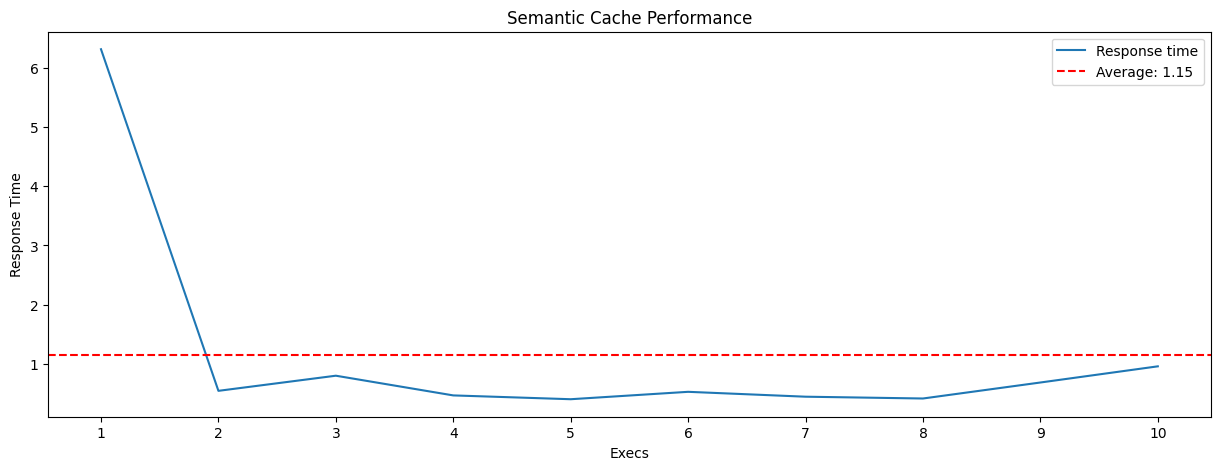

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


exec = 2
execs = []
prompts = ["Why is the sky blue?",
           "What makes the sky blue?",
           "Why does the sky is blue colored?",
           "Can you explain why the sky is blue?",
           "The sky is blue, why is that?"]
for i in range(exec):
  for prompt in prompts:
    start_time = time.time()
    model.invoke(prompt)
    response_time = time.time() - start_time
    execs.append(response_time)

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(execs, columns=['Response time'])
df['Exec'] = range(1, len(df) + 1)
df.plot(kind='line', x='Exec', y='Response time', legend=False)
plt.title('Semantic Cache Performance')
plt.xlabel('Executions')
plt.ylabel('Response Time')
plt.xticks(df['Exec'], rotation=0)

average = df['Response time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()